In [1]:
pip install neptune-client

In [2]:
import pandas as pd
import numpy as np

from collections import Counter

from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
    api_token=API_TOKEN,
    project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
dataset.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


PatientID - string / int: binary encoding jest nie do zrobienia, hash encoding zostawia int

In [6]:
dataset['PatientId'] = dataset['PatientId'].apply(lambda x: str(int(x)))

AppointmentID - drop


In [7]:
dataset.drop('AppointmentID',axis=1, inplace=True)
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Gender: F-0, M-1

In [8]:
dataset['Gender'] = dataset['Gender'].factorize()[0]

In [9]:
dataset['Gender'] = dataset['Gender'].apply(lambda x: str(x))

In [10]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Scheduleday, Appointmentday - datetime

In [11]:
dataset['AppointmentDay'] = pd.to_datetime(dataset.AppointmentDay)

In [12]:
dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay)

add column waiting days


In [13]:
dataset['Waiting_Time_days'] = dataset['AppointmentDay'] - dataset['ScheduledDay']
dataset['Waiting_Time_days'] = dataset['Waiting_Time_days'].dt.days
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,29872499824296,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,558997776694438,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4262962299951,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,867951213174,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8841186448183,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1


In [14]:
dataset[dataset['Waiting_Time_days'] <0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,29872499824296,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,558997776694438,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4262962299951,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,867951213174,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8841186448183,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110511,823599626588,0,2016-06-08 08:50:20+00:00,2016-06-08 00:00:00+00:00,14,MARIA ORTIZ,0,0,0,0,0,0,No,-1
110512,98762456447375,0,2016-06-08 08:20:01+00:00,2016-06-08 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0,No,-1
110513,86747784995281,1,2016-06-08 07:52:55+00:00,2016-06-08 00:00:00+00:00,2,ANTÔNIO HONÓRIO,0,0,0,0,0,0,No,-1
110514,2695685177138,0,2016-06-08 08:35:31+00:00,2016-06-08 00:00:00+00:00,58,MARIA ORTIZ,0,0,0,0,0,0,No,-1


In [15]:
dataset = dataset[dataset['Waiting_Time_days'] >=0]

In [16]:
dataset[dataset['Waiting_Time_days'] <0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


add column scheduledweekday and appointmentweekday

0- pn
6 - nd

In [17]:
dataset['ScheduledWeekday'] = dataset['ScheduledDay'].dt.dayofweek
dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek

In [18]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
5,95985133231274,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1,2,4
6,733688164476661,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4
7,3449833394123,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4
9,78124564369297,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1,2,4
10,734536231958495,0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,1,2,4


In [19]:
dataset['AppointmentMonth'] = dataset['AppointmentDay'].dt.month

In [20]:
dataset['AppointmentDay'] = dataset['AppointmentDay'].dt.day

In [21]:
dataset['ScheduledHour'] = dataset['ScheduledDay'].dt.hour

In [22]:
dataset['ScheduledMonth'] = dataset['ScheduledDay'].dt.month

In [23]:
dataset['ScheduledDay'] = dataset['ScheduledDay'].dt.day

In [24]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,No,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,No,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,No,1,2,4,4,14,4


In [25]:
#dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay)
#dataset['AppointmentDay'] = pd.to_datetime(dataset.AppointmentDay).dt.date.astype('datetime64[ns]')
#dataset['ScheduleTime'] = dataset.ScheduledDay.dt.time
#dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay).dt.date.astype('datetime64[ns]')
#dataset.head()

Age

In [26]:
dataset[dataset['Age']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth


In [27]:
dataset = dataset[dataset['Age'] >=0]

In [28]:
dataset[dataset['Age']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth


Scholarship, Hipertension 	Diabetes 	Alcoholism 	Handcap 	SMS_received 	No-show 

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientId           71959 non-null  object
 1   Gender              71959 non-null  object
 2   ScheduledDay        71959 non-null  int64 
 3   AppointmentDay      71959 non-null  int64 
 4   Age                 71959 non-null  int64 
 5   Neighbourhood       71959 non-null  object
 6   Scholarship         71959 non-null  int64 
 7   Hipertension        71959 non-null  int64 
 8   Diabetes            71959 non-null  int64 
 9   Alcoholism          71959 non-null  int64 
 10  Handcap             71959 non-null  int64 
 11  SMS_received        71959 non-null  int64 
 12  No-show             71959 non-null  object
 13  Waiting_Time_days   71959 non-null  int64 
 14  ScheduledWeekday    71959 non-null  int64 
 15  AppointmentWeekday  71959 non-null  int64 
 16  AppointmentMonth    7

In [30]:
dataset['Scholarship'] = dataset['Scholarship'].apply(lambda x: str(x))

In [31]:
dataset['Hipertension'] = dataset['Hipertension'].apply(lambda x: str(x))

In [32]:
dataset['Diabetes'] = dataset['Diabetes'].apply(lambda x: str(x))

In [33]:
dataset['Alcoholism'] = dataset['Alcoholism'].apply(lambda x: str(x))

In [34]:
dataset['Handcap'] = dataset['Handcap'].apply(lambda x: str(x))

In [35]:
dataset['SMS_received'] = dataset['SMS_received'].apply(lambda x: str(x))

In [36]:
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

In [37]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,2,4,4,14,4


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientId           71959 non-null  object
 1   Gender              71959 non-null  object
 2   ScheduledDay        71959 non-null  int64 
 3   AppointmentDay      71959 non-null  int64 
 4   Age                 71959 non-null  int64 
 5   Neighbourhood       71959 non-null  object
 6   Scholarship         71959 non-null  object
 7   Hipertension        71959 non-null  object
 8   Diabetes            71959 non-null  object
 9   Alcoholism          71959 non-null  object
 10  Handcap             71959 non-null  object
 11  SMS_received        71959 non-null  object
 12  No-show             71959 non-null  int64 
 13  Waiting_Time_days   71959 non-null  int64 
 14  ScheduledWeekday    71959 non-null  int64 
 15  AppointmentWeekday  71959 non-null  int64 
 16  AppointmentMonth    7

Neighbourhood  - binary endoding / hash encoding

In [39]:
binaryDataset = dataset.copy()

In [40]:
binaryDataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,2,4,4,14,4


In [41]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Neighbourhood'])
binaryDataset = encoder.fit_transform(binaryDataset)

binaryDataset.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,4,4,14,4


In [42]:
binaryDataset['Neighbourhood_7'].unique()

array([1, 0])

In [43]:
y = binaryDataset["No-show"]
y.head()

5     0
6     1
7     1
9     0
10    0
Name: No-show, dtype: int64

In [44]:
X = binaryDataset.loc[:, binaryDataset.columns != 'No-show']
X.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,4,4,15,4
7,3449833394123,0,27,29,39,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,4,4,15,4
9,78124564369297,0,27,29,19,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,4,4,14,4


model

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

In [46]:
def model(X, y, model, name, tags):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  model = model()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
      'recall', recall_score(y_test, y_pred), '\n',
      'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(model),"Magdalena Cebula"])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  #roc
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

Datasets

random under - sapling - od Janka

In [47]:
from imblearn.under_sampling import RandomUnderSampler

In [48]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 61.28%
 f1  0.3408633944411591 
 recall 0.34748010610079577 
 precision 0.3344939647168059
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-31
Confusion matrix:
 [[7378 2867]
 [2706 1441]]


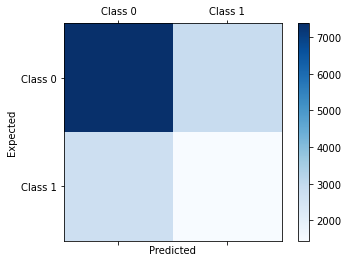

[0.         0.27984383 1.        ] [0.         0.34748011 1.        ] [2 1 0]


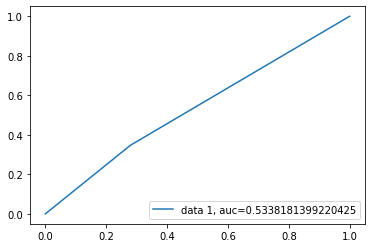

In [49]:
model(X, y, DecisionTreeClassifier, "random under-sampling", ['binaryEncoding', "random under-sampling" ])

random over-sampling

In [50]:
from imblearn.over_sampling import RandomOverSampler

In [51]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 80.32%
 f1  0.8209912020867413 
 recall 0.9035616971584274 
 precision 0.7522482378676173
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-32
Confusion matrix:
 [[7241 3058]
 [ 991 9285]]


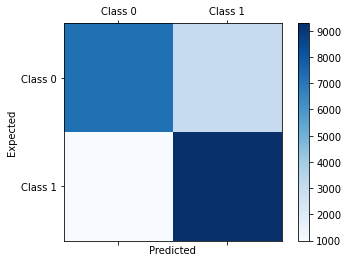

[0.         0.29692203 1.        ] [0.        0.9035617 1.       ] [2 1 0]


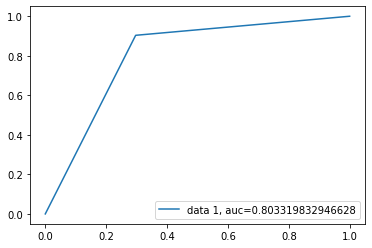

In [52]:
model(X_ros, y_ros, DecisionTreeClassifier, "random over-sampling", ['binaryEncoding', "random over-sampling" ])

SMOTE&Tomek

In [53]:
smote_tomek = SMOTETomek(random_state=0)
X_stomek, y_stomek = smote_tomek.fit_resample(X, y)
print(sorted(Counter(y_stomek).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0, 40949), (1, 40949)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 82.03%
 f1  0.7815375482338973 
 recall 0.64486896889542 
 precision 0.991713747645951
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-33
Confusion matrix:
 [[8170   44]
 [2900 5266]]


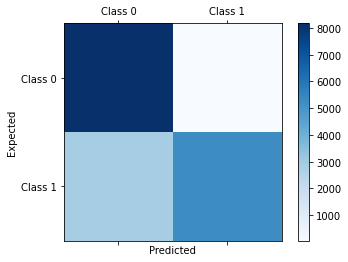

[0.         0.00535671 1.        ] [0.         0.64486897 1.        ] [2 1 0]


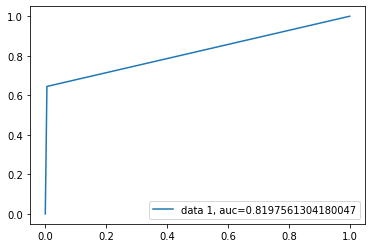

In [54]:
model(X_stomek, y_stomek, XGBClassifier, "SMOTETomek", ['binaryEncoding', "SMOTETomek" ])

Nearmiss

In [55]:
from imblearn.under_sampling import NearMiss

In [56]:
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 73.01%
 f1  0.6842405243659162 
 recall 0.5887690044139284 
 precision 0.8166666666666667
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-34
Confusion matrix:
 [[3592  539]
 [1677 2401]]


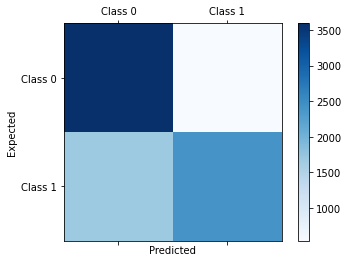

[0.         0.13047688 1.        ] [0.       0.588769 1.      ] [2 1 0]


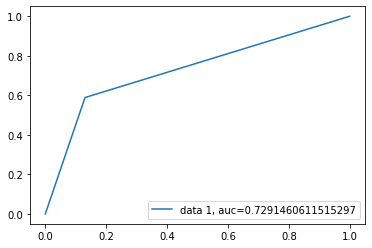

In [57]:
model(X_nm, y_nm, XGBClassifier, "Nearmiss", ['binaryEncoding', "Nearmiss" ])

adasyn

In [58]:
from imblearn.over_sampling import ADASYN

In [59]:
ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 79.26%
 f1  0.7335522161889128 
 recall 0.5802617121166717 
 precision 0.9969109318688862
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-35
Confusion matrix:
 [[10317    18]
 [ 4202  5809]]


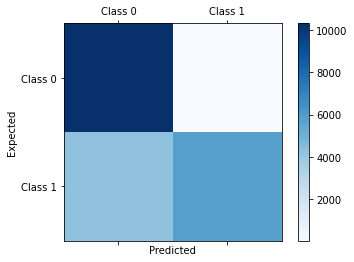

[0.         0.00174165 1.        ] [0.         0.58026171 1.        ] [2 1 0]


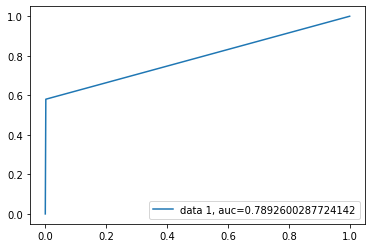

In [60]:
model(X_ada, y_ada, XGBClassifier, "ADASYN", ['binaryEncoding', "ADASYN" ])

Under-sampling: Cluster Centroids

In [61]:
from imblearn.under_sampling import ClusterCentroids 

In [62]:
cc = ClusterCentroids(random_state=42)

In [ ]:
X_cc, y_cc = cc.fit_resample(X, y)

In [ ]:
model(X_cc, y_cc, XGBClassifier, "Cluster Centroids", ['binaryEncoding', "Cluster Centroids"])

Bibliography:
*   http://enroute.pl/transformacja-zmiennych-kategorycznych-dummies/
*   https://www.featureranking.com/tutorials/machine-learning-tutorials/data-preparation-for-machine-learning/
*   https://kiwidamien.github.io/encoding-categorical-variables.html
*   https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

*   Binary encoding:
    https://www.datacamp.com/community/tutorials/categorical-data
*   Label encoding:
  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

*   Porównanie klasyfikatorów:
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html



https://colab.research.google.com/github/neptune-ai/neptune-colab-examples/blob/master/neptune_test_run.ipynb#scrollTo=G6hnHaoZDl9u
